Bài toán trở thành việc dự đoán góc lái của bô lăng bằng ảnh ở camera trên ô tô

In [0]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.models import Sequential 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Lambda, Conv2D, Dropout, Dense, Flatten
from keras.regularizers import l2

try:
  from utils import INPUT_SHAPE, batch_generator
except:
  !git clone https://github.com/nttuan8/DL_Tutorial
  import sys
  sys.path.insert(1, '/content/DL_Tutorial/L8')
  from utils import INPUT_SHAPE, batch_generator

In [0]:
# Tải data
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1QcMJtVft_DqrA9onQwOHQ6mKdiv91Xka', dest_path='./self-driving-car.zip', unzip=True)

In [0]:
data_dir = '/content/dataset'
train_df = pd.read_csv(os.path.join(data_dir, 'driving_log.csv'))
train_df.head()

In [0]:
# data preprocessing
data = pd.read_csv('/content/dataset/driving_log.csv', names=['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])
data.head()

In [0]:
center = data['center'].values
center = np.array(['/content/dataset/IMG/' + os.path.basename(i.replace('\\', '/')) for i in center]).reshape(-1, 1)

left = data['left'].values
left = np.array(['/content/dataset/IMG/' + os.path.basename(i.replace('\\', '/')) for i in left]).reshape(-1, 1)

right = data['right'].values
right = np.array(['/content/dataset/IMG/' + os.path.basename(i.replace('\\', '/')) for i in right]).reshape(-1,1)

(array([ 55.,  14.,  10.,  34.,   0., 439.,   5.,   4.,   5.,  48.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

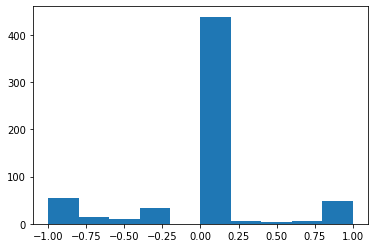

In [70]:
# Thư mục để dữ liệu
data_dir = '/content/dataset'

# Đọc file driving_log.csv với các cột tương ứng
data_df = pd.read_csv(os.path.join(os.getcwd(), data_dir, 'driving_log.csv'), 
                      names=['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])

# Lấy đường dẫn đến ảnh ở camera giữa, trái, phải
#X = data_df[['center', 'left', 'right']].values
X = np.concatenate((center, left, right), axis = 1)
# Lấy góc lái của ô tô
y = data_df['steering'].values

# Vẽ histogram dữ liệu
plt.hist(y)

array(['/content/dataset/IMG/center_2019_11_08_13_06_47_470.jpg',
       '/content/dataset/IMG/left_2019_11_08_13_06_47_470.jpg',
       '/content/dataset/IMG/right_2019_11_08_13_06_47_470.jpg'],
      dtype='<U55')

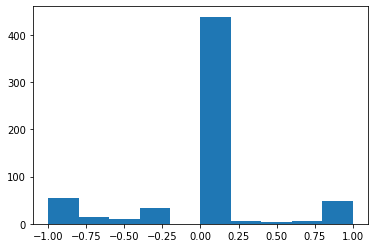

In [71]:
# Loại bỏ và chỉ lấy 1000 dữ liệu có góc lái ở 0
pos_zero = np.array(np.where(y==0)).reshape(-1, 1)
pos_none_zero = np.array(np.where(y!=0)).reshape(-1, 1)
np.random.shuffle(pos_zero)
pos_zero = pos_zero[:1000]

pos_combined = np.vstack((pos_zero, pos_none_zero))
pos_combined = list(pos_combined)

y = y[pos_combined].reshape(len(pos_combined))
X = X[pos_combined, :].reshape((len(pos_combined), 3))

# After process
plt.hist(y)
X[0]

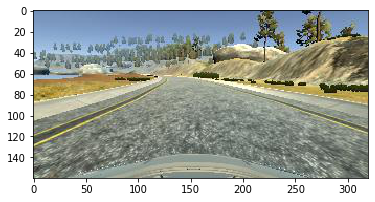

In [72]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(X[0][0])
imgplot = plt.imshow(img)
plt.show()

In [0]:
# Chia ra traing set và validation set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

In [74]:
X_train.shape

(491, 3)

In [21]:
X_valid.shape

(123, 3)

In [0]:
# xay dung model
model = Sequential()
model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE)) # các giá trị điểm ảnh thuộc [-1, 1]
model.add(Conv2D(24, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(36, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(48, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(64, 3, 3, activation='elu'))
model.add(Conv2D(64, 3, 3, activation='elu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))

In [0]:
# Thư mục chứa checkpoint
checkpoint_dir = './model'
# Mẫu tên checkpoint
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch:03d}.h5")

In [0]:
# Training

nb_epoch = 10
samples_per_epoch = 1000
batch_size = 32
save_best_only = True
learning_rate = 1e-4

# Checkpoint này để nói cho model lưu lại model nếu validation loss thấp nhất
checkpoint = ModelCheckpoint(checkpoint_prefix,
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='auto')

# Dùng mean_squrared_error làm loss function
model.compile(loss='mean_squared_error', optimizer=Adam(lr=learning_rate))

# Train model
H = model.fit_generator(batch_generator(data_dir, X_train, y_train, batch_size, True),
                    steps_per_epoch = samples_per_epoch,
                    epochs = nb_epoch,
                    max_q_size=1,
                    validation_data=batch_generator(data_dir, X_valid, y_valid, batch_size, False),
                    nb_val_samples=len(X_valid),
                    #callbacks=[checkpoint],
                    use_multiprocessing=False,
                    verbose=1)